# Network Building

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pip 


Usage:   
  /usr/local/bin/python3 -m pip <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion   

In [3]:

class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise

### UNet (not working yet)

In [4]:
import torch
import torch.nn as nn

class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetEncoderBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.relu = nn.ReLU()
   
    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.relu(x)
        return x


class UNet(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
   
                                     

        # Encoder
        self.encoder = nn.ModuleList([
            UNetEncoderBlock(in_channels, 64)#,
            #UNetEncoderBlock(64, 128),
            #UNetEncoderBlock(128, 256),
            #UNetEncoderBlock(256, 512),
            #UNetEncoderBlock(512, 1024)
        ])
       
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
           #nn.ReLU(),
            #nn.Conv1d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU()
        )
       
        # Decoder
        self.decoder = nn.ModuleList([
            #UNetDecoderBlock(2048, 1024),
            #UNetDecoderBlock(1024, 512),
           # UNetDecoderBlock(512, 256),
            #UNetDecoderBlock(256, 128),
            #UNetDecoderBlock(128, 64),
            UNetDecoderBlock(64, out_channels)
        ])

    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for layer in self.encoder:
            x = layer(x)
            encoder_outputs.append(x)

        # Bottleneck
        x = self.bottleneck(x)
        decoder_outputs = []
        # Decoder
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            decoder_outputs.append(x)
            
   
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
    
        # Compute binary cross-entropy loss
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(y_hat, y)
    
        # Log loss for monitoring
        self.log('train_loss', loss, on_step=True, on_epoch=True)
    
        return loss
        
    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
        return optimizer


In [5]:
from torchsummary import summary
in_channels = 1
out_channels = 1
model = UNet(in_channels, out_channels)

# Print the model summary
summary(model, input_size=(1,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 64]             256
              ReLU-2               [-1, 64, 64]               0
  UNetEncoderBlock-3               [-1, 64, 64]               0
            Conv1d-4               [-1, 64, 64]          12,352
              ReLU-5               [-1, 64, 64]               0
   ConvTranspose1d-6               [-1, 1, 128]             193
              ReLU-7               [-1, 1, 128]               0
  UNetDecoderBlock-8               [-1, 1, 128]               0
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.05
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [6]:
fake_input = torch.randn(1, 1, 64)  # Assuming 64 time steps
model = UNet(in_channels=1, out_channels=1)
# Print the output shape for verification
print("Fake Input Shape:", fake_input.shape)
output = model(fake_input)
print("Output Shape:", output.shape)

Fake Input Shape: torch.Size([1, 1, 64])
Output Shape: torch.Size([1, 1, 128])


  0%|          | 0/100 [00:00<?, ?it/s]

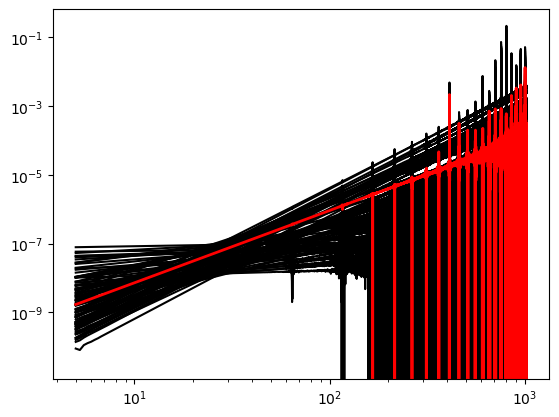

In [21]:
fref = 25
CE_PSD = np.genfromtxt("cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)
for i in range(len(samples)):
    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

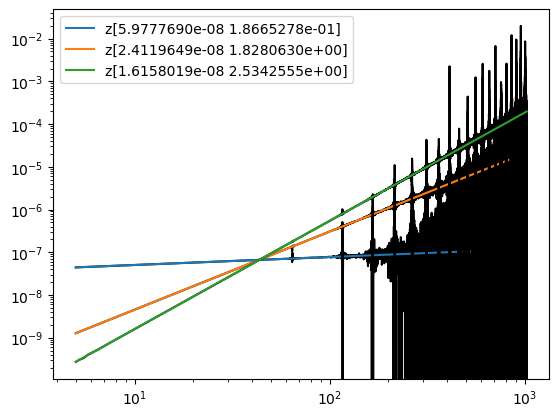

In [22]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [27]:
#def round(obs, bounds=None):
    
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
samples = sim.sample(20000) #20000 training samples
dm = swyft.SwyftDataModule(samples, batch_size=32) #traing w samples
trainer = swyft.SwyftTrainer(accelerator="gpu", precision = 32)
   
network = UNet(in_channels=1, out_channels=1)

trainer.fit(network, dm) #fit network

prior_samples = sim.sample(N = 10000, targets=['z']) #simulate ratio estimation
predictions = trainer.infer(network, obs, prior_samples) #predictions
new_bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold=1e-2) #set new bounds for priors
#return predictions, new_bounds, samples

  0%|          | 0/20000 [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | ModuleList | 256   
1 | bottleneck | Sequential | 12.4 K
2 | decoder    | ModuleList | 193   
------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [ ]:
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)

bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(5):
    predictions, bounds, samples = round(obs, bounds =bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

In [ ]:
# Normal ReLu
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

In [ ]:
# Batch Normalization
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

In [ ]:
# Swish Activation
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])


In [ ]:
# Leaky Relu
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])
